In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from tqdm import tqdm 
import time
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision.models.resnet import ResNet18_Weights
import pickle
import random
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
import statistics
import matplotlib.pyplot as plt

/raid/ganesh/namitha/miniconda3/envs/submodlib-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models.set_transformer import *
from models.LeNet_model import LeNet

In [3]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda:5" # change the available gpu number
else:
    device = "cpu"

In [4]:
split_ratio = 0.8
num_epochs = 10

In [5]:
# Define data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR10 datasets
train_dataset = datasets.CIFAR10(root="../data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
n_samples = len(test_dataset)
n_test = int(n_samples * split_ratio)
n_val = n_samples - n_test
test_dataset, val_dataset = random_split(test_dataset, [n_test, n_val])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, drop_last=True)

In [7]:
ls = [0, 10, 99, 150]
targets_tensor = torch.tensor(train_dataset.targets)
labels = targets_tensor[torch.tensor(ls)]
print(labels)

tensor([6, 4, 1, 3])


In [9]:
epochs = 100

# Initialize models
model = LeNet().to(device)
set_transformer = SetTransformer(
    dim_input=1000, 
    num_outputs=256, 
    dim_output=1, 
    num_inds=32, 
    dim_hidden=128, 
    num_heads=4, 
    ln=False
).to(device)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
model_optimizer = optim.Adam(model.parameters())
transformer_optimizer = optim.Adam(set_transformer.parameters())

feature_extracter = torchvision.models.resnet18(weights=None).to(device) 

selection = "hard"
start_time = time.time()

acc_list_st = []

for epoch in tqdm(range(epochs)):  # num_epochs is defined by you
    model.train()
    set_transformer.eval()
    # classification task training
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        image_feautres = feature_extracter(images)
        
        with torch.no_grad():  # We don't update set transformer during the model update phase
            # selection_scores = set_transformer(image_feautres).sigmoid() 
            selection_scores = set_transformer(image_feautres.unsqueeze(0))

        if selection == 'soft':
            weights = selection_scores / selection_scores.sum()  # Normalize scores to use as weights
            outputs = model(images)
            loss = (criterion(outputs, labels) * weights).mean() 
            # Not subset modelling 
        elif selection == 'hard':
            _, topk_indices = torch.topk(selection_scores.squeeze(), k=min(128, selection_scores.numel()))  # Example: select top 64 for training
            selected_inputs = images[topk_indices]
            selected_labels = labels[topk_indices]
            outputs = model(selected_inputs)
            loss = criterion(outputs, selected_labels)
        
        # Backward pass and update weights
        model_optimizer.zero_grad()
        loss.backward()
        model_optimizer.step()

    # updating set transformer parameters
    set_transformer.train()  # Set transformer is updated based on model's validation performance
    model.eval()
    val_losses = []
    val_loss_sum = torch.tensor(0.0, device=device)
    
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        image_feautres = feature_extracter(images)

        with torch.no_grad():  # We don't update set transformer during the model update phase
            # selection_scores = set_transformer(image_feautres).sigmoid() 
            selection_scores = set_transformer(image_feautres.unsqueeze(0))

        if selection == 'soft':
            weights = selection_scores / selection_scores.sum()  # Normalize scores to use as weights
            outputs = model(images)
            loss = (criterion(outputs, labels) * weights).mean() 
            # Not subset modelling 
        elif selection == 'hard':
            _, topk_indices = torch.topk(selection_scores.squeeze(), k=min(128, selection_scores.numel()))  # Example: select top 64 for training
            selected_inputs = images[topk_indices]
            selected_labels = labels[topk_indices]
            outputs = model(selected_inputs)
            loss = criterion(outputs, selected_labels)
        
        val_loss_sum += loss

        # loss = criterion(outputs, labels)
        # val_loss_sum += loss
    
    val_loss_mean = val_loss_sum / len(val_dataloader)
    transformer_optimizer.zero_grad()
    val_loss_mean.backward()  # This part needs careful handling; see note below
    transformer_optimizer.step()

    # Evaluate on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    # print(f"Accuracy for epoch {epoch}: {accuracy:.4f}")
    acc_list_st.append(accuracy)

time_taken = time.time()-start_time
print(f"time taken for {epochs} epochs: {time_taken}")

100%|██████████| 100/100 [13:59<00:00,  8.40s/it]

time taken for 100 epochs: 839.5789432525635


In [13]:
if selection=="hard":
    hard_list = acc_list_st
else:
    soft_list = acc_list_st

In [2]:
hard_list = [0.325375,0.405125,0.443,0.46725,0.4875,0.5095, 0.5175,0.51425,0.525375,0.538375,0.539375,0.5485, 0.558625,0.561,0.56925,0.576875,0.563,0.56475,0.586375, 0.581875,0.58, 0.58775, 0.59475, 0.605125, 0.600125, 0.606, 0.6035, 0.6025, 0.59825, 0.613625, 0.614, 0.6125, 0.610625, 0.616125, 0.618875, 0.630375,0.6255, 0.610875, 0.62, 0.61725, 0.620625, 0.623375, 0.6265, 0.631625, 0.619875, 0.63175, 0.628625, 0.64225, 0.632125, 0.6365, 0.646, 0.64, 0.632125, 0.63275, 0.644, 0.634, 0.63225, 0.637375, 0.640375, 0.641, 0.629125, 0.6315, 0.6485, 0.650375, 0.642, 0.64975, 0.6495, 0.643625, 0.656375, 0.65275, 0.648625,0.655375, 0.648, 0.648, 0.654125, 0.652125, 0.655125, 0.659375, 0.656375, 0.661, 0.6605, 0.666125, 0.6625, 0.6645, 0.66425, 0.666625, 0.667625, 0.661875, 0.669, 0.678625, 0.670625, 0.670125, 0.66525, 0.660125,0.673125,0.67625,0.6715,0.674875,0.672,0.662]

100

In [2]:
soft_list = [0.39475, 0.4335, 0.472125, 0.4915, 0.518375, 0.530375, 0.545, 0.5395, 0.556875, 0.55975, 0.572625, 0.56925, 0.58275, 0.59, 0.58725, 0.588375, 0.600875, 0.615875, 0.605, 0.603875, 0.619, 0.620125, 0.626625, 0.621125, 0.63175, 0.64, 0.632125, 0.6315, 0.642125, 0.639875, 0.651625, 0.65125, 0.65225, 0.650875, 0.653875, 0.653375, 0.66, 0.66175, 0.661125, 0.66475, 0.663875, 0.674375, 0.664625, 0.6615, 0.67225, 0.6735, 0.6785, 0.67625, 0.678625, 0.6725, 0.685875, 0.678875, 0.691875, 0.6815, 0.68275, 0.680625, 0.687125, 0.6825, 0.694, 0.683125, 0.690125, 0.686, 0.688875, 0.690125, 0.688125, 0.69575, 0.692125, 0.69575, 0.698625, 0.68625, 0.69225, 0.69875, 0.69425, 0.695, 0.696, 0.706375, 0.70275, 0.69775, 0.692125, 0.69325, 0.701125, 0.707375, 0.701125, 0.696, 0.701125, 0.706375, 0.702875, 0.70525, 0.703875, 0.701375, 0.710375, 0.698, 0.70925, 0.699625, 0.70475, 0.703375, 0.706, 0.69775, 0.70225, 0.7005]

In [3]:
hard_list_50 = [0.3775, 0.447375, 0.472625, 0.498875, 0.49675, 0.500625, 0.516125, 0.522375, 0.535875, 0.535375, 0.52625, 0.548625, 0.545, 0.556625, 0.56075, 0.573, 0.580125, 0.574875, 0.57875, 0.569875, 0.5945, 0.584125, 0.591875, 0.593375, 0.584625, 0.605875, 0.601125, 0.595, 0.609375, 0.6135, 0.618875, 0.611, 0.607625, 0.60475, 0.61825, 0.62125, 0.623375, 0.628875, 0.628875, 0.63575, 0.631125, 0.6355, 0.637625, 0.637875, 0.63625, 0.6455, 0.6345, 0.64825, 0.651125, 0.646375, 0.647625, 0.641, 0.64075, 0.646625, 0.649, 0.655, 0.64925, 0.649375, 0.64675, 0.650875, 0.65575, 0.645125, 0.652375, 0.655, 0.6595, 0.655125, 0.658625, 0.651375, 0.6595, 0.65575, 0.666625, 0.659875, 0.659, 0.67125, 0.665375, 0.654, 0.672375, 0.661125, 0.666, 0.65325, 0.66425, 0.6655, 0.674, 0.6755, 0.67675, 0.661375, 0.67625, 0.67375, 0.665375, 0.672, 0.672, 0.683, 0.672125, 0.680875, 0.671625, 0.659, 0.67725, 0.6775, 0.68275, 0.68675]

### Rewight Meta

In [6]:
acc_list_reweight = [0.443, 0.474, 0.502125, 0.517625, 0.55175, 0.539375, 0.57025, 0.56775, 0.58375, 0.5895, 0.601, 0.594375, 0.597, 0.602375, 0.607625, 0.59725, 0.61525, 0.6085, 0.618375, 0.621875, 0.621375, 0.626625, 0.627875, 0.631625, 0.634375, 0.633, 0.648625, 0.626, 0.64075, 0.640125, 0.63975, 0.63575, 0.641375, 0.6385, 0.634125, 0.64725, 0.647625, 0.643375, 0.64825, 0.65025, 0.652, 0.645875, 0.65525, 0.652875, 0.653625, 0.661, 0.64675, 0.658125, 0.656625, 0.6595, 0.65175, 0.654125, 0.664, 0.659375, 0.657125, 0.6315, 0.653625, 0.670625, 0.649875, 0.656625, 0.657625, 0.66325, 0.664875, 0.6645, 0.657, 0.663625, 0.666, 0.667375, 0.664625, 0.65875, 0.68375, 0.66475, 0.667625, 0.671875, 0.670375, 0.674875, 0.663125, 0.676875, 0.66975, 0.66975, 0.676, 0.67425, 0.679, 0.665, 0.67625, 0.67, 0.671875, 0.67325, 0.6685, 0.676125, 0.67425, 0.6745, 0.6805, 0.687125, 0.67975, 0.675625, 0.680125, 0.692875, 0.692375, 0.686375]

In [16]:
idx_list = []
for idx, (i, j) in enumerate(zip(soft_list, acc_list_reweight)):
    if i > j:
        idx_list.append(idx)

print(idx_list)

[17, 25, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


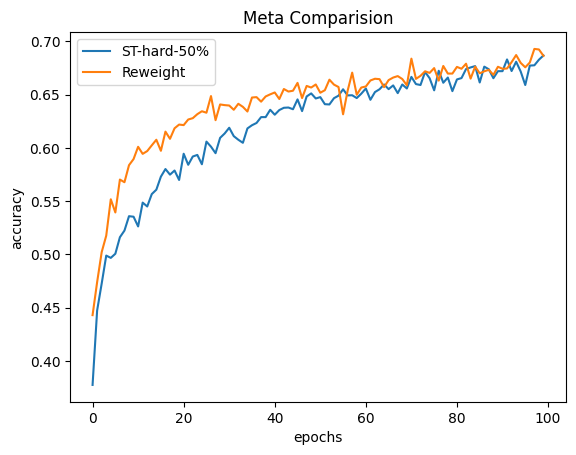

In [8]:
x = range(len(soft_list))

# Plot both lines
# plt.plot(x, hard_list, label='ST-hard')
plt.plot(x, hard_list_50, label='ST-hard-50%')
plt.plot(x, acc_list_reweight, label='Reweight-100%')

# Add labels and title
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Meta Comparision')

# Add legend
plt.legend()

# Show plot
plt.show()